# Looking at the historical impact of cyclones

This notebook reviews the strength of past cyclones, any CERF allocations and people affected.

In [112]:
%load_ext jupyter_black
import geopandas as gpd
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from shapely.geometry import LineString
import os
from datetime import datetime
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as ticker

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [90]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
# read in file with the people affected
emdat_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "emdat"
    / "emdat-tropicalcyclone-2000-2022-processed-sids.csv"
)
emdat_file = pd.read_csv(emdat_path)

# read in file with CERF allocations
cerf_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cerf"
    / "cerf-storms-with-sids-2024-02-27.csv"
)
cerf_file = pd.read_csv(cerf_path)

In [91]:
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]

In [92]:
ibtracs_path = adm1_path = Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)

In [93]:
assert gdf_points.crs == gdf_sel.crs
gdf_points_sel = gpd.sjoin(gdf_points, gdf_sel, how="inner", predicate="intersects")
gdf_points_sel = gdf_points_sel[gdf_points_sel["year"] >= 1980]
gdf_points_sel_ = gdf_points_sel[
    [
        "SID",
        "ADM1_PT",
        "NAME",
        "ISO_TIME",
        "REU_WIND",
        "WMO_WIND",
        "USA_WIND",
        "geometry",
    ]
].sort_values("ISO_TIME")

In [94]:
# combining US Wind and REUnion for those with no wind speed
gdf_points_sel_["REU_USA_WIND"] = gdf_points_sel_["REU_WIND"].fillna(
    gdf_points_sel_["USA_WIND"] * 0.88
)
gdf_points_sel_ = (
    gdf_points_sel_.groupby(["SID", "NAME"]).max("REU_USA_WIND").reset_index()
)

In [95]:
def categorize_storm_knots(speed_knots):
    """
    Categorize the storm based on its wind speed in knots.

    Parameters:
    speed_knots (float): Wind speed in knots.

    Returns:
    str: Storm category.
    """
    # Convert knots to km/h
    speed_kmh = speed_knots * 1.852

    if speed_kmh < 63:
        return "Depression"
    elif 63 <= speed_kmh < 89:
        return "Moderate Tropical Storm"
    elif 89 <= speed_kmh < 118:
        return "Severe Tropical Storm"
    elif 118 <= speed_kmh < 166:
        return "Tropical Cyclone"
    elif 166 <= speed_kmh < 212:
        return "Intense Tropical Cyclone"
    else:
        return "Very Intense Tropical Cyclone"

In [96]:
gdf_points_sel_["REU_CAT"] = [
    categorize_storm_knots(speed) for speed in gdf_points_sel_["REU_USA_WIND"]
]

In [97]:
gdf_points_sel_.tail(10)

,SID,NAME,REU_WIND,WMO_WIND,USA_WIND,REU_USA_WIND,REU_CAT
30,2019063S18038,IDAI,85.0,85.0,100.0,85.00,Tropical Cyclone
31,2019112S10053,KENNETH,20.0,20.0,NaN,20.00,Depression
32,2020355S11065,CHALANE,55.0,50.0,58.0,55.00,Severe Tropical Storm
33,2021012S12086,ELOISE,75.0,70.0,83.0,75.00,Tropical Cyclone
34,2021042S23040,GUAMBE,28.0,25.0,25.0,28.00,Depression
35,2022020S13059,ANA,NaN,NaN,48.0,42.24,Moderate Tropical Storm
36,2022065S16055,GOMBE,NaN,NaN,90.0,79.20,Tropical Cyclone
37,2022110S12051,JASMINE,NaN,NaN,35.0,30.80,Depression
38,2023061S22036,FREDDY,NaN,NaN,89.0,78.32,Tropical Cyclone
39,2024071S20039,FILIPO,NaN,NaN,51.0,44.88,Moderate Tropical Storm


In [98]:
# showing plots showing cyclone intensity, cerf allocations and people affected
moz_emdat = emdat_file[
    (emdat_file["Country"] == "Mozambique") & (emdat_file["Disaster Type"] == "Storm")
]

In [99]:
moz_cerf = cerf_file[
    (cerf_file["Country"] == "Mozambique") & (cerf_file["Emergency"] == "Storm")
]

In [100]:
moz_cerf

,Country,Allocation date,Amount in US$,Window,Emergency,Status,iso2,asap0_id,allocation_year,sid
49,Mozambique,05/04/2023,9995213,Rapid Response,Storm,Completed,MZ,33,2023,2023061S22036
50,Mozambique,07/04/2022,4018682,Rapid Response,Storm,Report Available,MZ,33,2022,2022065S16055
51,Mozambique,16/05/2019,9964907,Rapid Response,Storm,Report Available,MZ,33,2019,2019112S10053
52,Mozambique,28/03/2019,14018121,Rapid Response,Storm,Report Available,MZ,33,2019,2019063S18038
53,Mozambique,17/03/2017,2000095,Rapid Response,Storm,Report Available,MZ,33,2017,2017043S19040
54,Mozambique,20/03/2008,548913,Rapid Response,Storm,Report Available,MZ,33,2008,2008062S10064
55,Mozambique,13/12/2007,1070014,Rapid Response,Storm,Report Available,MZ,33,2007,2007043S11071


In [101]:
# combine into one object
# Standardize column names for the merge
moz_emdat = moz_emdat.rename(columns={"sid": "SID"})
moz_cerf = moz_cerf.rename(columns={"sid": "SID"})
# Merge the DataFrames on the 'SID' column
merged_df = pd.merge(
    pd.merge(
        gdf_points_sel_, moz_emdat[["SID", "Total Affected"]], on="SID", how="outer"
    ),
    moz_cerf[["SID", "Amount in US$"]],
    on="SID",
    how="outer",
)

In [135]:
merged_df_clean = merged_df[
    (merged_df["NAME"] != "UNNAMED") & (merged_df["NAME"].notna())
]
merged_df_clean = merged_df_clean[merged_df_clean["SID"].str[:4].astype(int) >= 1998]
merged_df_clean.tail(5)

,SID,NAME,REU_WIND,WMO_WIND,USA_WIND,REU_USA_WIND,REU_CAT,Total Affected,Amount in US$
36,2022020S13059,ANA,NaN,NaN,48.0,42.24,Moderate Tropical Storm,185636.0,NaN
37,2022065S16055,GOMBE,NaN,NaN,90.0,79.20,Tropical Cyclone,736123.0,4018682.0
38,2022110S12051,JASMINE,NaN,NaN,35.0,30.80,Depression,NaN,NaN
39,2023061S22036,FREDDY,NaN,NaN,89.0,78.32,Tropical Cyclone,NaN,9995213.0
40,2024071S20039,FILIPO,NaN,NaN,51.0,44.88,Moderate Tropical Storm,NaN,NaN


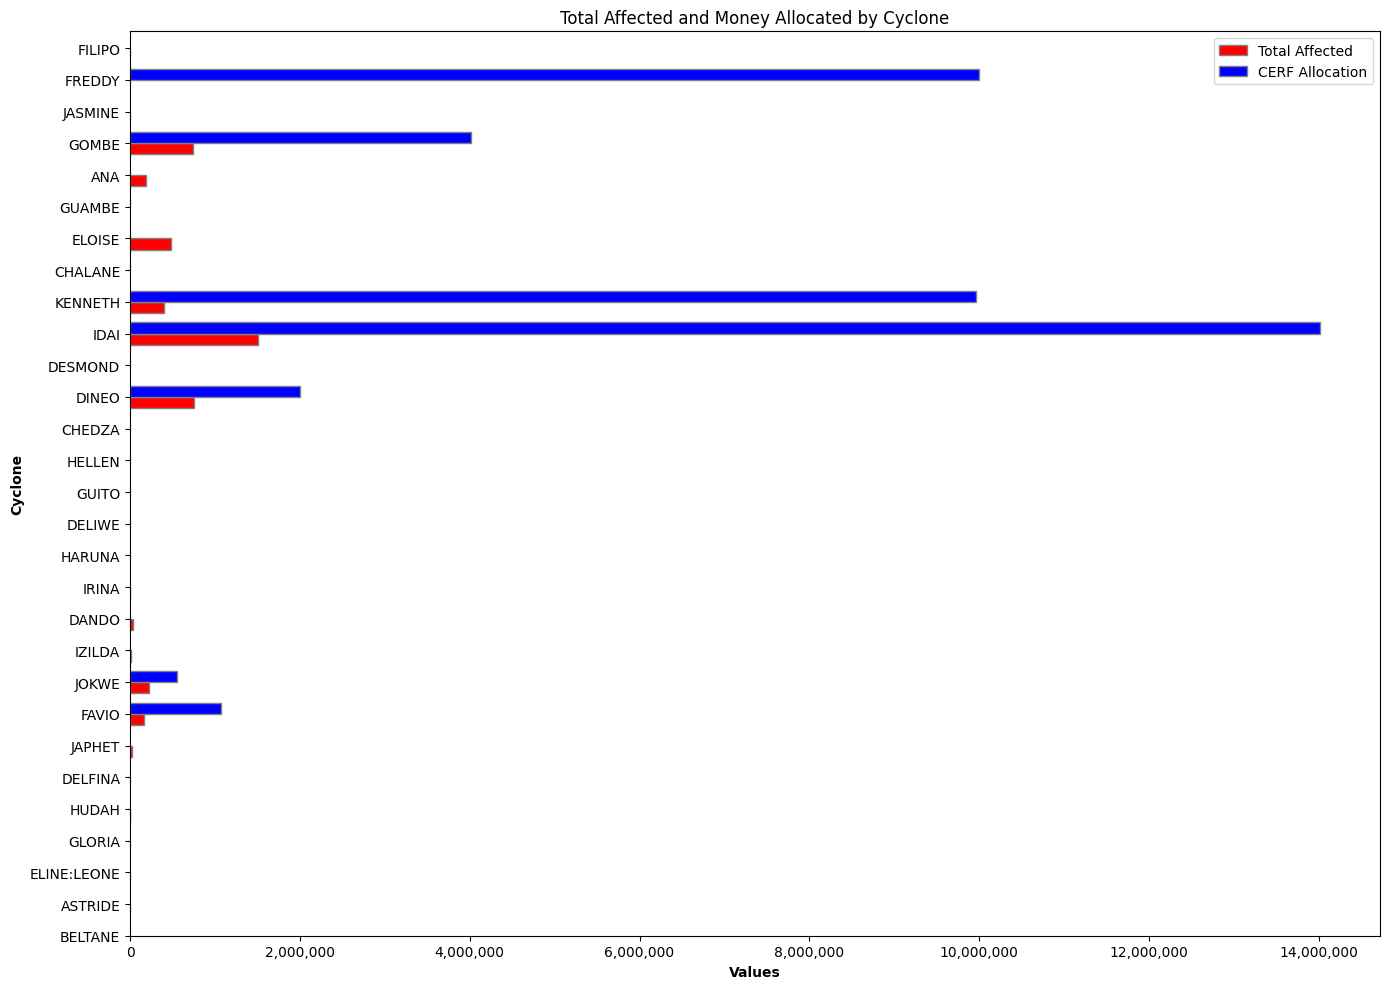

In [136]:
# Create a horizontal bar plot
plt.figure(figsize=(14, 10))

# Set the position of bars on the y-axis
bar_width = 0.35
r1 = range(len(merged_df_clean))
r2 = [x + bar_width for x in r1]

# Plot the total affected
plt.barh(
    [r for r in r1],
    merged_df_clean["Total Affected"],
    color="r",
    height=bar_width,
    edgecolor="grey",
    label="Total Affected",
)

# Plot the money allocated
plt.barh(
    [r + bar_width for r in r1],
    merged_df_clean["Amount in US$"],
    color="b",
    height=bar_width,
    edgecolor="grey",
    label="CERF Allocation",
)

# Add yticks at the middle of the group bars
plt.ylabel("Cyclone", fontweight="bold")
plt.xlabel("Values", fontweight="bold")
plt.title("Total Affected and Money Allocated by Cyclone")
plt.yticks(
    [r + bar_width / 2 for r in range(len(merged_df_clean))],
    merged_df_clean["NAME"],
)

# Set the y-axis to display actual values
formatter = ticker.StrMethodFormatter("{x:,.0f}")  # Format number with commas
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

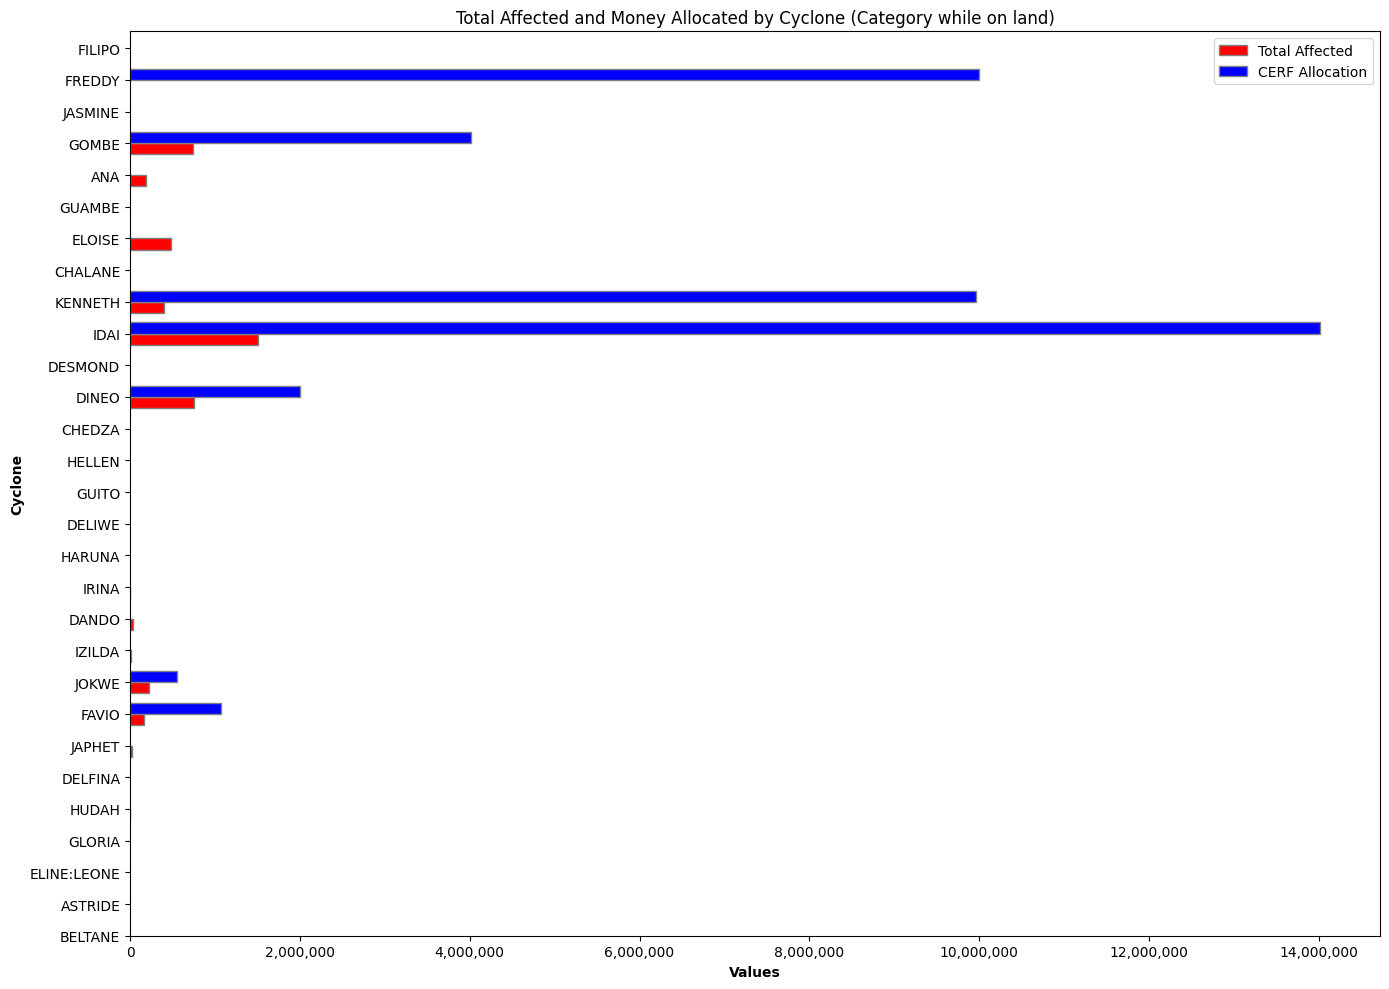

In [138]:
# Create a horizontal bar plot
plt.figure(figsize=(14, 10))

# Set the position of bars on the y-axis
bar_width = 0.35
r1 = range(len(merged_df_clean))
r2 = [x + bar_width for x in r1]

# Plot the total affected
plt.barh(
    [r for r in r1],
    merged_df_clean["Total Affected"],
    color="r",
    height=bar_width,
    edgecolor="grey",
    label="Total Affected",
)

# Plot the money allocated
plt.barh(
    [r + bar_width for r in r1],
    merged_df_clean["Amount in US$"],
    color="b",
    height=bar_width,
    edgecolor="grey",
    label="CERF Allocation",
)

# Add yticks at the middle of the group bars
plt.ylabel("Cyclone", fontweight="bold")
plt.xlabel("Values", fontweight="bold")
plt.title("Total Affected and Money Allocated by Cyclone (Category while on land)")

# Create labels with the first letter of each word in the category
labels_with_initials = [
    f"{name} ({''.join([word[0].upper() for word in category.split()])})"
    for name, category in zip(merged_df_clean["NAME"], merged_df_clean["REU_CAT"])
]

# Update yticks with new labels
plt.yticks(
    [r + bar_width / 2 for r in range(len(merged_df_clean))], merged_df_clean["NAME"]
)
# Set the x-axis to display actual values
formatter = ticker.StrMethodFormatter("{x:,.0f}")  # Format number with commas
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()